In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

# Configurações visuais (Estética dos gráficos)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. CARREGAMENTO
# Substitua pelo nome exato do seu arquivo se for diferente
FILE_PATH = "dataset_crawler-google-places_2025-11-10_22-46-50-107.json"

try:
    with open(FILE_PATH, 'r', encoding='utf-8') as f:
        data = json.load(f)
        # Transforma o JSON em uma tabela (DataFrame)
        df = pd.json_normalize(data)
        print(f"Sucesso! Carregadas {df.shape[0]} linhas e {df.shape[1]} colunas.")
except Exception as e:
    print(f"Erro ao carregar o arquivo: {e}")

# Visualizar as primeiras linhas para garantir que deu certo
df.head(3)

Sucesso! Carregadas 15 linhas e 59 colunas.


,title,price,categoryName,address,neighborhood,street,city,postalCode,state,countryCode,...,additionalInfo.Público,additionalInfo.Planejamento,additionalInfo.Pagamentos,additionalInfo.Crianças,additionalInfo.Estacionamento,description,website,additionalInfo.Da empresa,additionalInfo.Animais de estimação,additionalOpeningHours.Almoço
0,Restaurante Gratidão - Restaurante comida por Kg,R$ 20–40,Restaurante,"Av. Paranaíba, 715 - Qd. 90, Lt. 86 - St. Cent...",Setor Central,"Av. Paranaíba, 715 - Qd. 90, Lt. 86",Goiânia,74015-125,Goiás,BR,...,[{'Empresa que acolhe a comunidade LGBTQ+': Tr...,[{'Aceita reservas': True}],"[{'Alelo': True}, {'Cartão de crédito': True},...","[{'Bom para ir com crianças': True}, {'Cadeiri...","[{'Há muitas vagas disponíveis': True}, {'Esta...",NaN,NaN,NaN,NaN,NaN
1,Restaurante Árabe,$$$,Empório gourmet,"Avenida 83, 205 - St. Sul, Goiânia - GO, 74083...",Setor Sul,"Avenida 83, 205",Goiânia,74083-020,Goiás,BR,...,NaN,[{'Visita rápida': True}],"[{'Cartão de crédito': True}, {'Cartão de débi...",NaN,"[{'Estacionamento coberto gratuito': True}, {'...","Comida árabe em casa ampla e elegante, com vit...",http://www.restaurantearabe.com.br/,NaN,NaN,NaN
2,Galpão Restaurante,R$ 20–40,Restaurante brasileiro,"R. 83, s/n - Sala 2 - St. Sul, Goiânia - GO, 7...",Setor Sul,"R. 83, s/n - Sala 2",Goiânia,74083-195,Goiás,BR,...,"[{'Grupos': True}, {'Universitários': True}]",[{'Aceita reservas': False}],"[{'Alelo': True}, {'Cartão de crédito': True},...",[{'Cardápio infantil': True}],"[{'É difícil encontrar uma vaga': True}, {'Est...",NaN,NaN,NaN,NaN,NaN


In [ ]:
# 2. LIMPEZA DE PREÇOS 

if 'price' in df.columns:
    # Função segura para limpar e categorizar os preços (sem cifrão nos labels)
    def clean_price_safe(value):
        value = str(value) # Garantir que é texto
        
        if '$$$' in value:
            return 'Preco Alto'       # Substitui $$$ por texto
        elif '$$' in value:
            return 'Preco Medio'      # Substitui $$ por texto
        elif value == '$':
            return 'Preco Baixo'      # Substitui $ por texto
        elif 'R$' in value:
            # Remove "R$", espaços invisíveis (\xa0) e espaços extras
            clean_val = value.replace('R$', '').replace('\xa0', '').strip()
            return f'Faixa {clean_val}'
        elif value in ['nan', 'None', '']:
            return 'Nao Informado'
        return 'Outros'

    # Aplica a função na coluna original e cria uma nova coluna limpa
    df['price_safe_label'] = df['price'].apply(clean_price_safe)

    print("Coluna de preços limpa com sucesso. Valores únicos encontrados:")
    print(df['price_safe_label'].unique())
else:
    print("Aviso: Coluna 'price' não encontrada.")

Coluna de preços limpa com sucesso. Valores únicos encontrados:
['Faixa 20–40' 'Preco Alto' 'Preco Medio' 'Nao Informado']


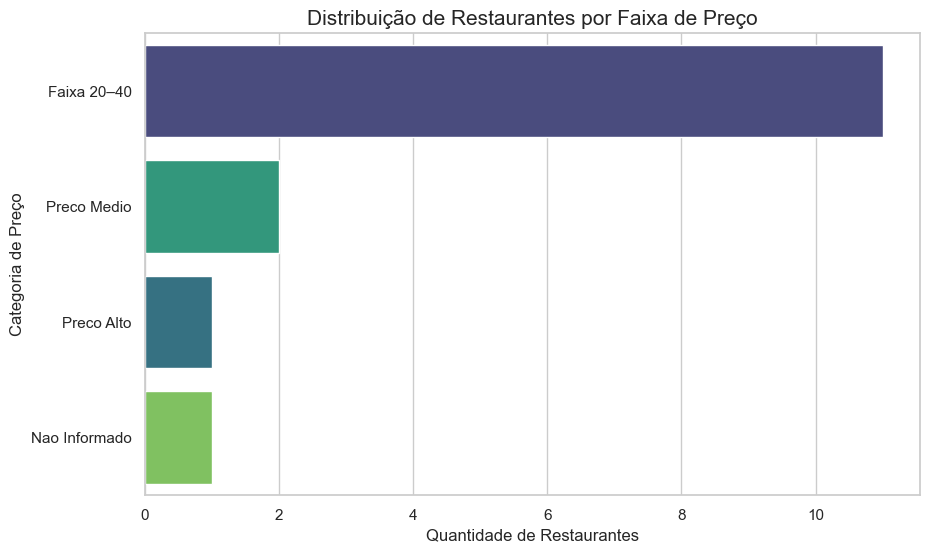

In [26]:
# 3. GRÁFICO: FAIXAS DE PREÇO MAIS COMUNS

plt.figure(figsize=(10, 6))

# Define a ordem das barras para ficar lógico no gráfico
# Só incluímos na ordem o que realmente existe nos dados
all_categories = ['Preco Baixo', 'Preco Medio', 'Preco Alto', 'Nao Informado']
# Pega as faixas dinâmicas (ex: "Faixa 20-40") que existirem
dynamic_ranges = [x for x in df['price_safe_label'].unique() if 'Faixa' in x]
order_price = all_categories + dynamic_ranges

# Plota o gráfico de contagem
sns.countplot(
    y='price_safe_label', 
    data=df, 
    order=df['price_safe_label'].value_counts().index, # Ordena do mais frequente para o menos
    hue='price_safe_label', 
    palette='viridis', 
    legend=False
)

plt.title('Distribuição de Restaurantes por Faixa de Preço', fontsize=15)
plt.xlabel('Quantidade de Restaurantes')
plt.ylabel('Categoria de Preço')
plt.show()

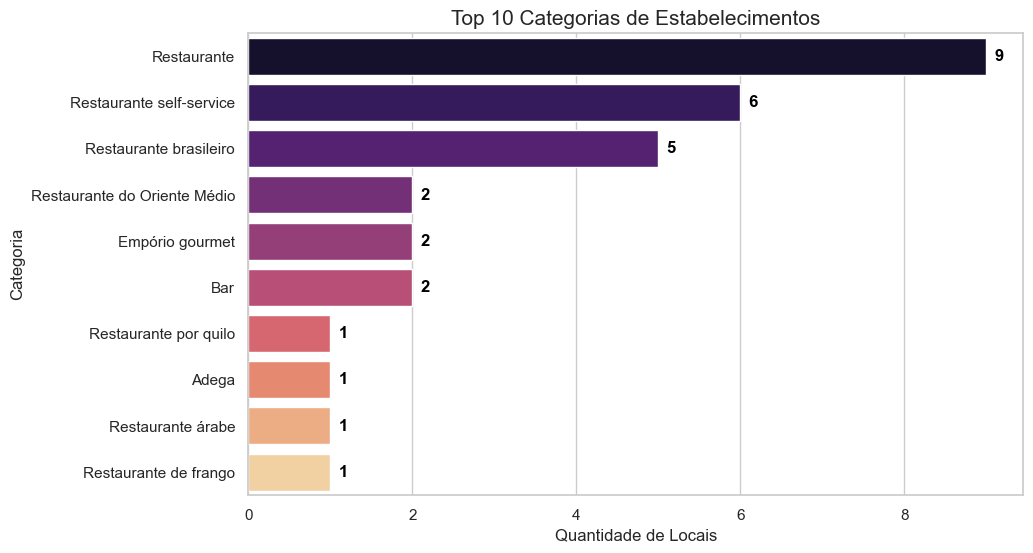

In [27]:
# 4. GRÁFICO: TOP 10 CATEGORIAS (O Perfil do Mercado)

# O campo 'categories' é uma lista. Vamos "explodir" (separar) para contar cada tag.
if 'categories' in df.columns:
    # Cria um novo DF onde cada categoria vira uma linha
    df_cat_exploded = df.explode('categories')

    # Conta as 10 mais frequentes
    top_categories = df_cat_exploded['categories'].value_counts().head(10)

    plt.figure(figsize=(10, 6))
    
    # Plota o gráfico de barras
    sns.barplot(
        x=top_categories.values, 
        y=top_categories.index, 
        hue=top_categories.index, 
        palette='magma', 
        legend=False
    )
    
    plt.title('Top 10 Categorias de Estabelecimentos', fontsize=15)
    plt.xlabel('Quantidade de Locais')
    plt.ylabel('Categoria')

    # Adiciona os números exatos na frente das barras
    for i, v in enumerate(top_categories.values):
        plt.text(v + 0.1, i, str(v), va='center', fontweight='bold', color='black')

    plt.show()
else:
    print("Aviso: Coluna 'categories' não encontrada.")

C:\Users\ACER\AppData\Local\Temp\ipykernel_17812\596847707.py:43: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


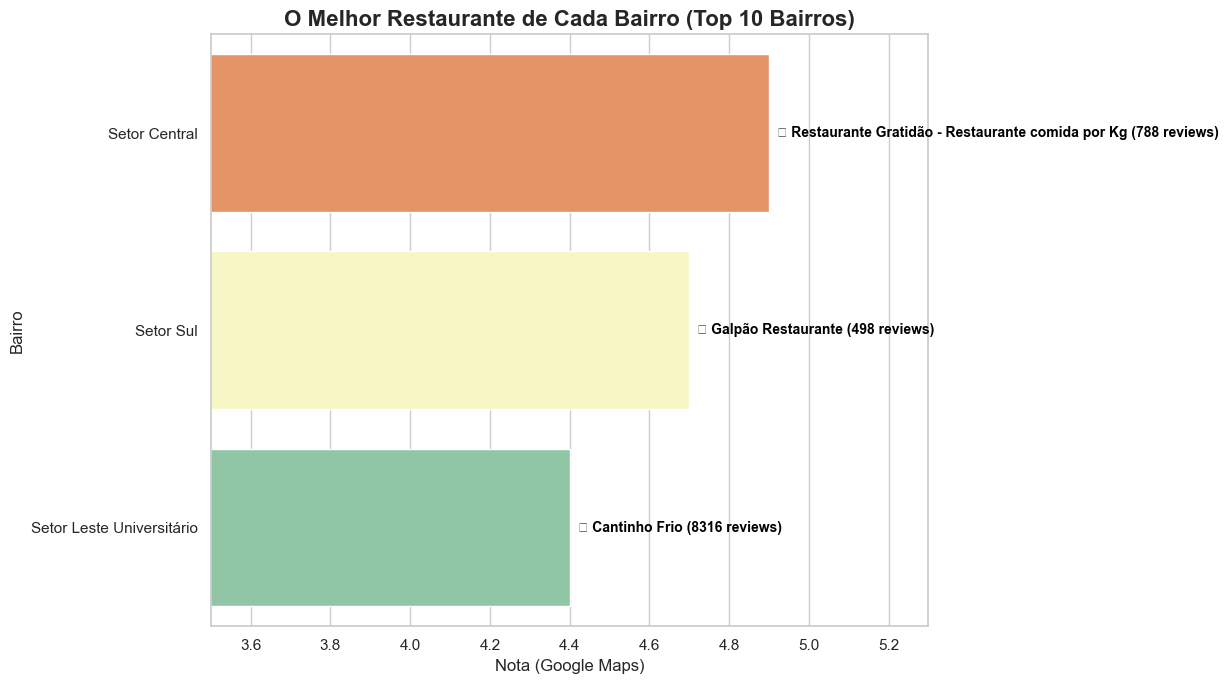

Detalhes dos Campeões:


,neighborhood,title,totalScore,reviewsCount,price
0,Setor Central,Restaurante Gratidão - Restaurante comida por Kg,4.9,788,R$ 20–40
2,Setor Sul,Galpão Restaurante,4.7,498,R$ 20–40
9,Setor Leste Universitário,Cantinho Frio,4.4,8316,$$


In [ ]:
# --- ANÁLISE 5 (NOVA): O CAMPEÃO DE CADA BAIRRO ---

# 1. Preparar os dados
# Removemos bairros vazios
df_geo = df[df['neighborhood'].notna()].copy()

# 2. Encontrar o "Campeão" de cada bairro
# Ordenamos por Bairro, depois Nota (decrescente) e Reviews (decrescente)
# Assim, o primeiro de cada bairro será o melhor
df_geo = df_geo.sort_values(by=['neighborhood', 'totalScore', 'reviewsCount'], ascending=[True, False, False])

# Removemos duplicatas de bairro, mantendo apenas o primeiro (o campeão)
df_best_per_hood = df_geo.drop_duplicates(subset=['neighborhood'], keep='first')

# 3. Filtrar: Vamos pegar apenas os top 10 bairros (para o gráfico caber na tela)
# Se quiser todos, basta remover o .head(10)
top_campeoes = df_best_per_hood.sort_values(by='totalScore', ascending=False).head(10)

# --- PLOTAGEM ---
plt.figure(figsize=(12, 7))

# Gráfico de barras horizontais
ax = sns.barplot(
    data=top_campeoes,
    y='neighborhood',
    x='totalScore',
    palette='Spectral', 
    hue='neighborhood',
    legend=False
)

plt.title('O Melhor Restaurante de Cada Bairro (Top 10 Bairros)', fontsize=16, fontweight='bold')
plt.xlabel('Nota (Google Maps)', fontsize=12)
plt.ylabel('Bairro', fontsize=12)
plt.xlim(3.5, 5.3) # Foca o gráfico nas notas altas (ajusta visualmente)

# Adicionar o NOME do restaurante dentro/ao lado da barra
for i, (nota, nome, reviews) in enumerate(zip(top_campeoes['totalScore'], top_campeoes['title'], top_campeoes['reviewsCount'])):
    # Posição do texto: um pouco antes do fim da barra para ficar dentro, ou depois se for curta
    texto_label = f"🏆 {nome} ({reviews} reviews)"
    ax.text(nota + 0.02, i, texto_label, va='center', fontweight='bold', color='black', fontsize=10)

plt.tight_layout()
plt.show()

# Exibir a tabela para conferência
print("Detalhes dos Campeões:")
top_campeoes[['neighborhood', 'title', 'totalScore', 'reviewsCount', 'price']]